<a href="https://colab.research.google.com/github/YoshifumiMiyagi/VinDr-PCXR/blob/main/VinDr_PCXR_vol_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
SEED=42
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize,LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_predict
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import KFold, StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,roc_curve, auc, classification_report, make_scorer,RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler,PowerTransformer, label_binarize
from sklearn.multiclass import OneVsRestClassifier


In [ ]:
annotation = pd.read_csv('/content/drive/MyDrive/annotations_train.csv')
annotation_test = pd.read_csv('/content/drive/MyDrive/annotations_test.csv')
annotation.head()

,image_id,rad_ID,class_name,x_min,y_min,x_max,y_max,class_id
0,03d56a9709a81b2e9d6afbc6647c8730,R3,Boot-shaped heart,378.760010,401.416645,835.143248,661.678438,0
1,48f7ba0b0fd5ab847ee87df2aed5cfc9,R3,Peribronchovascular interstitial opacity,247.196368,412.000819,441.763442,830.320028,1
2,48f7ba0b0fd5ab847ee87df2aed5cfc9,R3,Peribronchovascular interstitial opacity,613.631024,364.980443,902.238850,827.077243,1
3,74f8648d742bbcce79d67c967de5552d,R3,Peribronchovascular interstitial opacity,1008.515903,665.439667,1324.430364,1265.465119,1
4,74f8648d742bbcce79d67c967de5552d,R3,Peribronchovascular interstitial opacity,453.015307,635.756429,724.404911,1242.142575,1


In [10]:
ohe = OneHotEncoder(sparse=False)
df_new = pd.DataFrame(ohe.fit_transform(annotation.loc[:,"class_name"].values.reshape(-1, 1)),
                      columns=ohe.get_feature_names_out(),
                      index = annotation['image_id'],
                      dtype=np.int8)
df_new.columns = ['_'.join(col.split('_')[1:]) for col in df_new.columns]
A = df_new.groupby(level=0).sum()

df_new_test = pd.DataFrame(ohe.transform(annotation_test.loc[:,"class_name"].values.reshape(-1, 1)),
                      columns=ohe.get_feature_names_out(),
                      index = annotation_test['image_id'],
                      dtype=np.int8)
df_new_test.columns = ['_'.join(col.split('_')[1:]) for col in df_new.columns]
A_test = df_new_test.groupby(level=0).sum()

label = pd.read_csv('/content/drive/MyDrive/image_labels_train.csv')
label_test = pd.read_csv('/content/drive/MyDrive/image_labels_test.csv')

label4 = label[(label['Bronchitis']==1)|(label['Brocho-pneumonia']==1)|(label['Bronchiolitis']==1)|(label['Pneumonia']==1)].loc[:,['image_id','Bronchitis','Brocho-pneumonia','Bronchiolitis','Pneumonia']]
label_test4 = label_test[(label_test['Bronchitis']==1)|(label_test['Brocho-pneumonia']==1)|(label_test['Bronchiolitis']==1)|(label_test['Pneumonia']==1)].loc[:,['image_id','Bronchitis','Brocho-pneumonia','Bronchiolitis','Pneumonia']]

df_label = label4.iloc[:,1:].idxmax(axis=1)
df = pd.concat([label4.iloc[:,0],df_label],axis=1)
df.columns = ['image_id','class_name']

df_label_test = label_test4.iloc[:,1:].idxmax(axis=1)
df_test = pd.concat([label_test4.iloc[:,0],df_label_test],axis=1)
df_test.columns = ['image_id','class_name']

Df = pd.merge(A,df,on='image_id',how='inner') # train_test_dataset
Df_test = pd.merge(A_test,df_test,on='image_id',how='inner') # validation_dataset
Df.head()

(2157, 39) (409, 39)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,image_id,Anterior mediastinal mass,Aortic enlargement,Atelectasis,Boot-shaped heart,Bronchectasis,Bronchial thickening,Calcification,Cardiomegaly,Chest wall mass,...,Other opacity,Paraveterbral mass,Peribronchovascular interstitial opacity,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Reticulonodular opacity,Stomach on the right side,class_name
0,0008e7acbcdf2fedd05cc236e5594074,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,Brocho-pneumonia
1,008000749ecc9074e80562f9f90091fd,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,Bronchiolitis
2,00e5c7c8c64dcf9c2b85f2d92d67a1e3,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,Bronchiolitis
3,00e898fc3a6a95d56510c5c87fdbc03a,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,2,0,Brocho-pneumonia
4,01010180f98c184adc806d3bb53dd8e1,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,Bronchitis


In [13]:
le = LabelEncoder()

X_, y_ = Df.iloc[:,1:-1].values, le.fit_transform(Df["class_name"])
X_val, y_val = Df_test.iloc[:,1:-1].values, le.transform(Df_test["class_name"])

X_.shape, X_val.shape, y_.shape, y_val.shape

((2157, 37), (409, 37), (2157,), (409,))

# LR

In [93]:
cv = KFold(n_splits=5,shuffle=True,random_state=SEED)

In [94]:
pipe_LR =  make_pipeline(StandardScaler(),PowerTransformer(),LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))

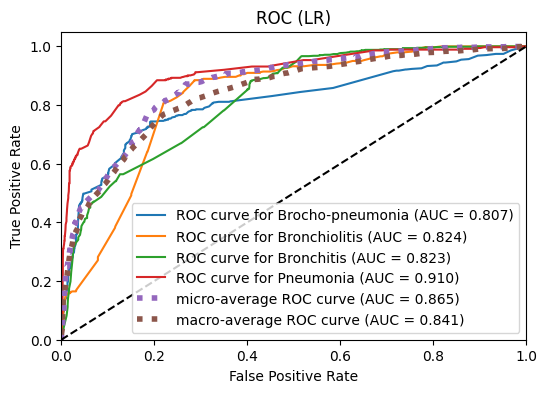

In [95]:
X, y = X_, y_
n_classes = len(le.classes_)

y_bin = label_binarize(y, classes=[0, 1, 2, 3])
classifier = OneVsRestClassifier(pipe_LR)
y_score = cross_val_predict(classifier, X, y_bin, cv=cv, method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(6, 4))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.3f})",)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (LR)')
plt.legend(loc="lower right")
plt.show()


# XGBoost

In [112]:
xgbc = XGBClassifier(random_state=SEED)

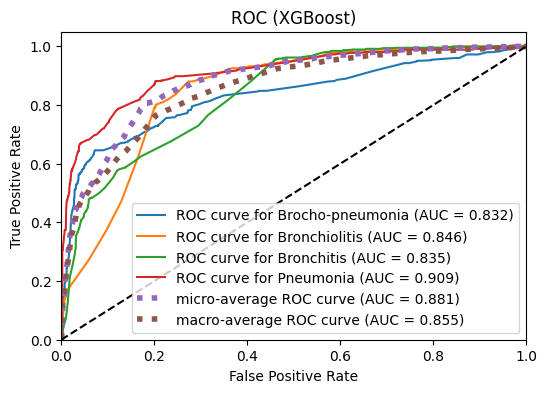

In [113]:
X, y = X_, y_
n_classes = len(le.classes_)

y_bin = label_binarize(y, classes=[0, 1, 2, 3])
classifier = OneVsRestClassifier(xgbc)
y_score = cross_val_predict(classifier, X, y_bin, cv=cv, method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(6, 4))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.3f})",)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (XGBoost)')
plt.legend(loc="lower right")
plt.show()

# LGBM

In [98]:
lgb = LGBMClassifier(random_state=SEED,boosting_type='gbdt',verbose = -1)

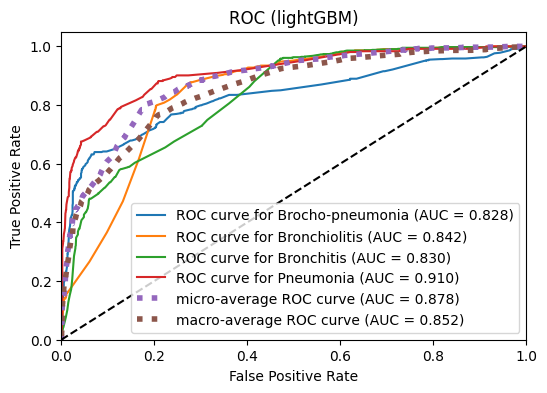

In [99]:
X, y = X_, y_
n_classes = len(le.classes_)

y_bin = label_binarize(y, classes=[0, 1, 2, 3])
classifier = OneVsRestClassifier(lgb)
y_score = cross_val_predict(classifier, X, y_bin, cv=cv, method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(6, 4))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.3f})",)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (lightGBM)')
plt.legend(loc="lower right")
plt.show()

# MLP

In [100]:
mlp = MLPClassifier(random_state=SEED)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

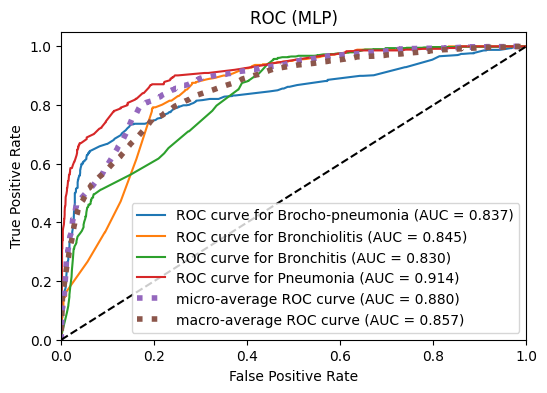

In [101]:
X, y = X_, y_
n_classes = len(le.classes_)

y_bin = label_binarize(y, classes=[0, 1, 2, 3])
classifier = OneVsRestClassifier(mlp)
y_score = cross_val_predict(classifier, X, y_bin, cv=cv, method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(6, 4))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.3f})",)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (MLP)')
plt.legend(loc="lower right")
plt.show()

# Stacking

In [102]:
CLF1 = make_pipeline(StandardScaler(), PowerTransformer(),LogisticRegression(C=0.1, penalty='l1', solver='liblinear',random_state=SEED))
#CLF2 = make_pipeline(StandardScaler(),SVC(probability=True,C=1, kernel='rbf',random_state=SEED))
#CLF3 = RandomForestClassifier(random_state=SEED,max_depth=3,min_samples_leaf=3,n_estimators=38,min_samples_split=8,max_leaf_nodes=10)
CLF4 =  make_pipeline(StandardScaler(), PowerTransformer(),ExtraTreesClassifier(random_state=SEED,max_depth=5, min_samples_leaf=2))
CLF5 = GradientBoostingClassifier(random_state=SEED,learning_rate=0.02,n_estimators=90,criterion='squared_error')
CLF6 =   LGBMClassifier(random_state=SEED,boosting_type='gbdt',verbose = -1)
#,
#                            n_estimators=50,reg_alpha=0.48062849104778112, reg_lambda=0.3183149895602818, num_leaves=3, colsample_bytree=0.4545491606995836,
#                            subsample=0.6285286325866263, subsample_freq=3, min_child_samples=5)
#CLF7 = make_pipeline(StandardScaler(), PowerTransformer(),GaussianNB())
CLF8 = MLPClassifier(random_state=SEED)
#CLF9 = make_pipeline(StandardScaler(), PowerTransformer(),MLPClassifier(random_state=SEED))
CLF10 =  make_pipeline(StandardScaler(), PowerTransformer(),ExtraTreesClassifier(random_state=SEED,max_depth=5, min_samples_leaf=2))
CLF11 =  XGBClassifier(random_state=SEED)

clf1 = LogisticRegression(C=0.07, penalty='l2', solver='lbfgs',random_state=SEED)
clf2 = SVC(probability=True,C=1, kernel='rbf',random_state=SEED)
clf3 = RandomForestClassifier(random_state=SEED,max_depth=4,min_samples_leaf=4,n_estimators=38)
clf4 = ExtraTreesClassifier(random_state=SEED,max_depth=5, min_samples_leaf=2)

In [103]:
from sklearn.ensemble import StackingClassifier
estimators = [
       ('lr', CLF1), ('xgbc', CLF11), ('lgbm', CLF6), ('mlp', CLF8)
        ]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=SEED)
)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

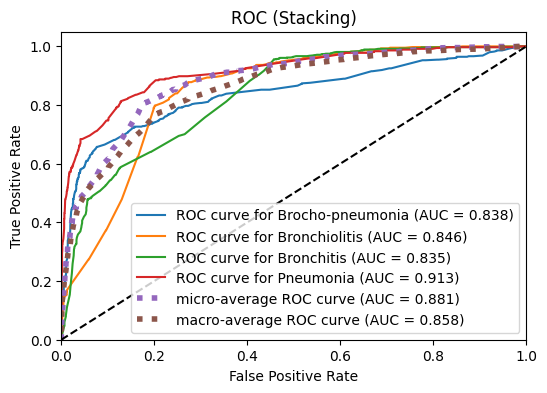

In [104]:
X, y = X_, y_
n_classes = len(le.classes_)

y_bin = label_binarize(y, classes=[0, 1, 2, 3])
classifier = OneVsRestClassifier(clf)
y_score = cross_val_predict(classifier, X, y_bin, cv=cv, method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(6, 4))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.3f})",)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Stacking)')
plt.legend(loc="lower right")
plt.show()

# Validation

In [106]:
clf.fit(X_, y_)
y_pred = clf.predict(X_val)
y_true = y_val

df_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
cm_default = confusion_matrix(y_true, y_pred )
df_cm = pd.DataFrame(cm_default, columns=le.classes_, index =le.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'


df_report.set_axis(['Brocho-pneumonia', 'Bronchiolitis', 'Bronchitis', 'Pneumonia', "accuracy", "macro avg","weighted avg"], axis="index")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

,precision,recall,f1-score,support
Brocho-pneumonia,0.666667,0.579710,0.620155,69.000000
Bronchiolitis,0.508621,0.694118,0.587065,85.000000
Bronchitis,0.630058,0.626437,0.628242,174.000000
Pneumonia,0.900000,0.666667,0.765957,81.000000
accuracy,0.640587,0.640587,0.640587,0.640587
macro avg,0.676336,0.641733,0.650355,409.000000
weighted avg,0.664457,0.640587,0.645594,409.000000


<Axes: xlabel='Predicted', ylabel='Actual'>

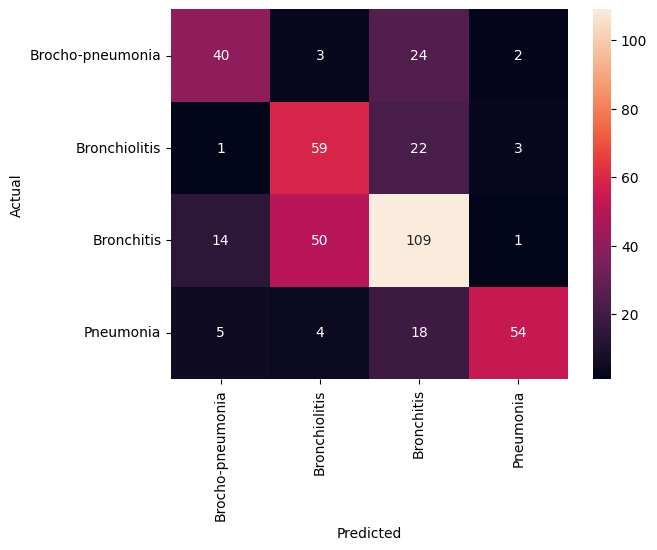

In [107]:
sns.heatmap(df_cm, annot=True,fmt=".0f")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

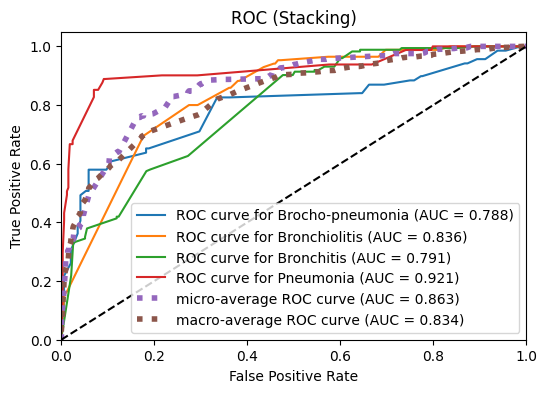

In [111]:
classifier = clf
y_score = classifier.fit(X_, y_).predict_proba(X_val)

label_binarizer = LabelBinarizer().fit(y_)
y_onehot_test = label_binarizer.transform(y_val)

fpr, tpr, roc_auc = dict(), dict(), dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(6, 4))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.3f})",)

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.3f})',
         linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC (Stacking)')
plt.legend(loc="lower right")
plt.show()